<a href="https://colab.research.google.com/github/aman5319/Meetup2019/blob/master/Session5/StyleTransfer%26DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install torch torchvision
!pip -q install Pillow==4.0.0

# for neuro audio style Transfer
!pip -q install librosa
!apt-get -q install ffmpeg

tcmalloc: large alloc 1073750016 bytes == 0x6239a000 @  0x7f7e117492a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import optim
from torchvision import datasets , transforms , models
from torch import nn

from PIL import Image, ImageFilter, ImageChops
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# [Style Transfer](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
Style transfer is damn easy and cool application to work on. It let's you generate artistic images.

So In plain english it takes two images **A Content  Image** and **A Style Image** and transfers the style to the content image.

![](https://datascience-enthusiast.com/figures/louvre_generated.png)

It uses pretained CNN model as a feature extractor that can separate and recombine the imagec ontent and style of natural images.

The algorithm allows  to produce new images of high perceptual quality that combine the content of an arbitrary photograph with the appearance of numerous well known artworks. 

### The most interesting thing about style transfer from my perspective is
1.  Super easy to implement
2. The reasearch paper is full of images and explanation is given in simple terms so a good starting point into reading reasearch paper.
3. Uses VGG16 network which is again easy to deal with.
4. Lot's of online tool to play around. https://deepart.io/#
5. Helps to get deeper understanding of CNNs.

In [3]:
# get the data 
!wget -q https://newevolutiondesigns.com/images/freebies/retro-wallpaper-35.jpg
!wget -q https://stmed.net/sites/default/files/tropical-wallpapers-28081-3502163.jpg
!wget -q https://assets.saatchiart.com/saatchi/698294/art/3752639/2822523-XBYPURAP-32.jpg
!mv retro-wallpaper-35.jpg deepDreamImage.jpg
!mv 2822523-XBYPURAP-32.jpg style.jpg
!mv tropical-wallpapers-28081-3502163.jpg content.jpg
!ls

content.jpg  deepDreamImage.jpg  sample_data  style.jpg


## Note :- Here the notebook for style transfer is written in a way that it only works for a single image at a time

In [0]:
#Imagenet mean and std to normalize the image with 
mean = np.array((0.485, 0.456, 0.406))
std = np.array((0.229, 0.224, 0.225))


In [0]:
def convert_Tensor(imgORpath , size):
  """I takes an PIL image or an Image path converts it in RGB and resizes it and return a normalized tensor image
      Arguments:
        imgORpath : either a pil image or an Image path
        size : the size of the final image
        shape: optional but the 
  """
  #load the image 
  
  if isinstance(imgORpath ,Path):
    image = Image.open(imgORpath)
  else:
    image = imgORpath
  image = image.convert("RGB")

  
  # some transformation
  transform = transforms.Compose([transforms.Resize(size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean,std) ])
  
  # increase the dimension for batch size=1
  image = transform(image).unsqueeze(dim=0)
  return image
      
content = convert_Tensor(Path("content.jpg") , size=(800,700)).to(device)
style = convert_Tensor(Path("style.jpg") , size=(800,700)).to(device)

In [0]:
# Actually pytorch use channel first format but matplotlib uses channel last format
def denormalize(image , norm=True):
  image = image.clone().detach().to("cpu")   # first clone the image and detach it and then transfer it to cpu 
  image = image.squeeze(0).numpy() #squeeze the extra single batch dimension and convert to numpy
  image = np.transpose(image , (1,2,0)) # swap the channels to bring channel to last
  if norm : image = image * std+mean # denormalize to get original image
  image = np.clip(image, 0,1) # clip all the values between 0 and 1 
  return image


Text(0.5, 1.0, 'style image')

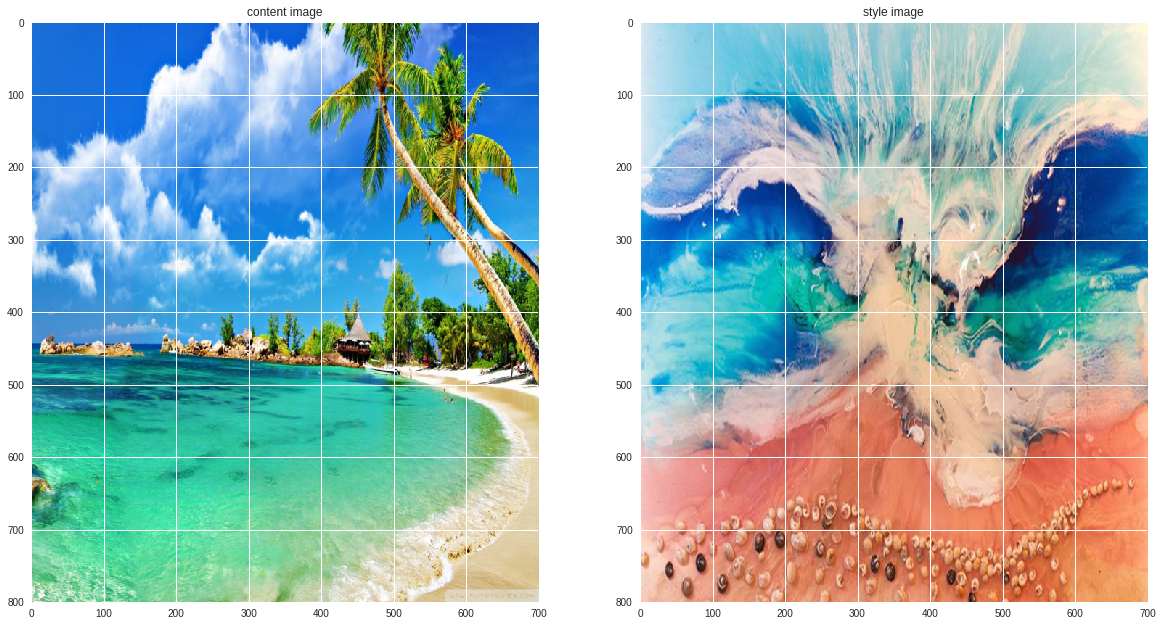

In [7]:
#visualizing the images
fig ,(ax1 , ax2) = plt.subplots(1,2 , figsize=(20,20))
ax1.imshow(denormalize(content))
ax1.set_title("content image")
ax2.imshow(denormalize(style))
ax2.set_title("style image")

In [8]:
# import model feature and load to gpu
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for x in vgg.parameters():
  x.requires_grad_(False)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:21<00:00, 27114250.11it/s]


 ## Vgg Architecutre
![](https://proxy.duckduckgo.com/iu/?u=http%3A%2F%2Fimage.slidesharecdn.com%2Fdeeplearningclass2-louismonier-160501185826%2F95%2Fdeep-learning-class-2-deep-learning-for-images-i-see-what-you-mean-12-638.jpg%3Fcb%3D1462253453&f=1)
  

As described in the paper:

we extract the style of the first convolution layer from each block 
1. conv1_1
2. conv2_1 
3. conv3_1
4. conv4_1
5. conv5_1

We do this because at different layer cnn gives different kinds of feature map from simple to complex features and we want to use all of those.
This creates images that match the style of a given image on an increasing scale while discarding information of the global arrangement of the scene.

For Content extraction we use the 2nd layer of forth block
1. conv4_2

Actually we can use any layer from any block for content and style extraction but this typical layers configuration  gave good results.



### How transfer works 
  1. Take the output for style image and content image in above given layers for which we use hook function which automatically returns the forward output at specific layers where it is called
  
  2. We calculate the output of different layers for target image every epoch and compare it with content image output and style image output and calculate the loss
  
  3. We use mean squared error loss because in this problem we are just trying to equalize to images
  
  4. while calculating the loss we compute two losses
      1. Content loss 
      2. Style Loss
      
   and then sum of both the losses and perform  the gradient update on target image.
   
  5. Calculating content loss is very simple just a mse loss at that particular layer
   
  6. Computing style loss is little different we compute gram matrix for those 5 specified layers  with respect to  style and target lmage and then for each layer calculate mse loss and then add up all the style loss for those 5 layer.
  
  $$
  total\ loss = content\ loss + style\ loss
 $$

In [9]:
#style block
style_blocks=[0]
style_blocks.extend([i+1 for i , layer in enumerate(vgg) if isinstance(layer , nn.MaxPool2d) and i+1 < len(vgg)])
print(style_blocks)

#content block so the 
content_blocks = [21]

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
      self.features = output
      self.hook.remove()
      
def load_features(images,model , blocks ):
  ef = [SaveFeatures(model[block]) for block in blocks]
  model(images)
  return ef
  
content_features = load_features(content , vgg , content_blocks)
style_features = load_features(style , vgg , style_blocks)

[0, 5, 10, 19, 28]


### Visualing feature maps.

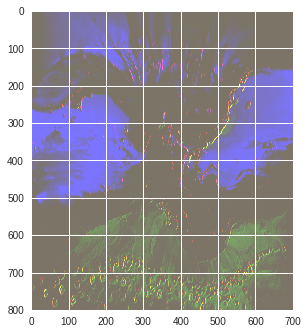

In [10]:
#get any three channels from a feature map, denormalize it, visualize it
plt.imshow(denormalize(style_features[0].features[: ,3:6 , : ,:]))

In [11]:
plt.imshow(denormalize(content_features[0].features[: ,3:6 , : ,:]))


We have Style loss and content loss but because they are computed differently there values will be  different .

We want our target image to take both into account fairly equally.

So this leads to introduction of two more parameters 
 1. alpha -> Multiplied by content loss
 2. Beta -> Multiplied by style loss
 
  $$
  total\ loss = \alpha * content\ loss + \beta * style\ loss
 $$
 
These two paramters greatly effect the amount of content and style goes into the target image .
 A very high beta value will lead to more of the style and less of the content in the target image and vice versa so tunning this two parameters can lead to an artistic image.

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
style_weights = (1.,0.75,0.5,0.5,0.2)

content_weight = 1  # alpha
style_weight = 2e7  # beta

# clone the content image as a starting point for the style transfer
target = content.clone().requires_grad_(True).to(device)

## Gram Matrix 

Here comes the most important part of this entire problem The Gram Matrix.

[Mathematically](https://en.wikipedia.org/wiki/Gramian_matrix)

$$
 G=V^{\mathrm {T} }V\       \ \\\\\  \left(where\ V\ is\ matrix \right)
$$

what actually we need is style of the image and style is in each pixel of the image and to get it we don't require the spatial information of the image, just throw the spatial information I don't care what is there is in the image, I need only style and also different channels of the feature map has different style so accounting of all that what we can do is.

1. Take a convolution output the feature map of let's say (b\*d\*h\*w) dimension
2. Take each channel one by one so their diemension is (1\*h\*w) 
3. Flatten it so the spatial information is lost but the style information is still preserved
4. Repeat this step for all channels of the feature map and stack them up to get a 2d matrix of dimension (d , h*w)

$$
Here\\
d\ is\ the\ depth\ of\ an\ feature\ map\\
h\ is\ the\ height\ of\ an\ feature\ map\\
w\ is\ the\ width\ of\ an\ feature\ map\\
$$

To perform all the steps from 1 to 5  in python 
```python
  b,d,h,w = t_tensor.shape
  tensor = t_tensor.view(d,w*h) # reshapng the tensor to desired size

```

Now that we have a 2d style matrix containing only the style of each channel and what do you think will happen if we take a transpose of that matrix and multiply with itself

 When we do matrix multiplication, we are performing a sum product among all the  channels.
 
 so all the channels multiplied by other channels gives information about the texture , color and overall style of the image. 
 
 To understand gram matrix and how it is used for style loss more visually and mathematically hop over to https://course.fast.ai/lessons/lesson13.html 

In [0]:
def gram_matrix(t_tensor):
  c,d,h,w = t_tensor.shape
  tensor = t_tensor.view(d,w*h)
  tensor = torch.mm(tensor , tensor.t())
  return tensor.div(c*d*h*w)

style_gram_matrix = [gram_matrix(layer.features) for layer in style_features]


In [14]:
style_gram_matrix

[tensor([[0.0063, 0.0025, 0.0024,  ..., 0.0062, 0.0015, 0.0033],
         [0.0025, 0.0067, 0.0025,  ..., 0.0047, 0.0014, 0.0033],
         [0.0024, 0.0025, 0.0067,  ..., 0.0001, 0.0021, 0.0032],
         ...,
         [0.0062, 0.0047, 0.0001,  ..., 0.0412, 0.0036, 0.0061],
         [0.0015, 0.0014, 0.0021,  ..., 0.0036, 0.0016, 0.0019],
         [0.0033, 0.0033, 0.0032,  ..., 0.0061, 0.0019, 0.0047]],
        device='cuda:0'),
 tensor([[0.0279, 0.0009, 0.0086,  ..., 0.0095, 0.0057, 0.0105],
         [0.0009, 0.0022, 0.0007,  ..., 0.0035, 0.0019, 0.0007],
         [0.0086, 0.0007, 0.0090,  ..., 0.0031, 0.0020, 0.0042],
         ...,
         [0.0095, 0.0035, 0.0031,  ..., 0.0356, 0.0134, 0.0050],
         [0.0057, 0.0019, 0.0020,  ..., 0.0134, 0.0245, 0.0118],
         [0.0105, 0.0007, 0.0042,  ..., 0.0050, 0.0118, 0.0179]],
        device='cuda:0'),
 tensor([[0.0172, 0.0066, 0.0013,  ..., 0.0046, 0.0028, 0.0052],
         [0.0066, 0.0525, 0.0149,  ..., 0.0131, 0.0041, 0.0130],
        

  0%|          | 0/2000 [00:00<?, ?it/s]

Total loss  is 1124.1304931640625 style loss 5.620652518700808e-05 content loss 0.0


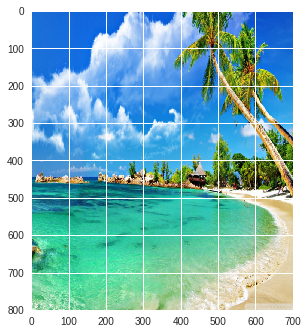

 20%|██        | 400/2000 [04:28<17:55,  1.49it/s]

Total loss  is 37.147987365722656 style loss 1.6481202465001843e-06 content loss 4.185581684112549


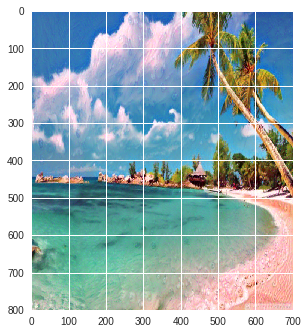

 40%|████      | 800/2000 [08:56<13:14,  1.51it/s]

Total loss  is 18.988080978393555 style loss 7.558853667433141e-07 content loss 3.8703744411468506


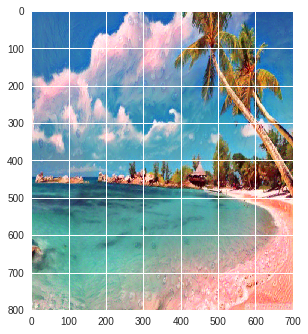

 60%|██████    | 1200/2000 [13:21<08:49,  1.51it/s]

Total loss  is 12.201492309570312 style loss 4.2673298139561666e-07 content loss 3.6668331623077393


 80%|████████  | 1600/2000 [17:46<04:24,  1.51it/s]

Total loss  is 9.101107597351074 style loss 2.7911949018744053e-07 content loss 3.5187180042266846


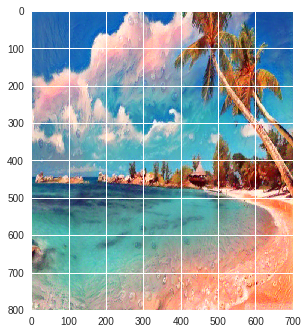

100%|██████████| 2000/2000 [22:11<00:00,  1.51it/s]


In [15]:
optimizer = optim.Adam([target] , lr=0.005) ## define the optimizer 

epoch=2000
each_step=400

for each_epoch in tqdm(range(epoch)):
  
  optimizer.zero_grad()
  
  target_features  = load_features(target , vgg, style_blocks+content_blocks) # get all the forward computation ouput for specified layer for the target
  
  content_loss = F.mse_loss(target_features[-1].features,content_features[0].features) # compute the content loss
  style_loss = 0
  
  ## calculate the style loss for each layer and then sum them up
  for layer ,sty_gram, weights in zip(target_features[:-1] , style_gram_matrix,style_weights):
    target_tensor = gram_matrix(layer.features) # calculate the gram matrix for target image
    layer_style_loss = weights * F.mse_loss(target_tensor ,sty_gram) # calulate the style loss
    style_loss += layer_style_loss # added them up
    
  total_loss = content_weight*content_loss + style_weight*style_loss #compute total loss
  total_loss.backward() 
  optimizer.step()
  ## show the image after every 400 epochs
  if each_epoch % each_step==0:
    print(f"Total loss  is {total_loss.item()} style loss {style_loss.item()} content loss {content_loss.item()}")
    plt.imshow(denormalize(target))
    plt.show()

In [16]:
def save(filepath, fig=None):
    '''Save the current image with no whitespace
    Example filepath: "myfig.png" or r"C:\myfig.pdf" 
    '''
    if not fig:
        fig = plt.gcf()

    plt.subplots_adjust(0,0,1,1,0,0)
    for ax in fig.axes:
        ax.axis('off')
        ax.margins(0,0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(filepath, pad_inches = 0, bbox_inches='tight')
    
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(denormalize(target))
save("finalResult.jpg")


Text(0.5, 1.0, 'style image')

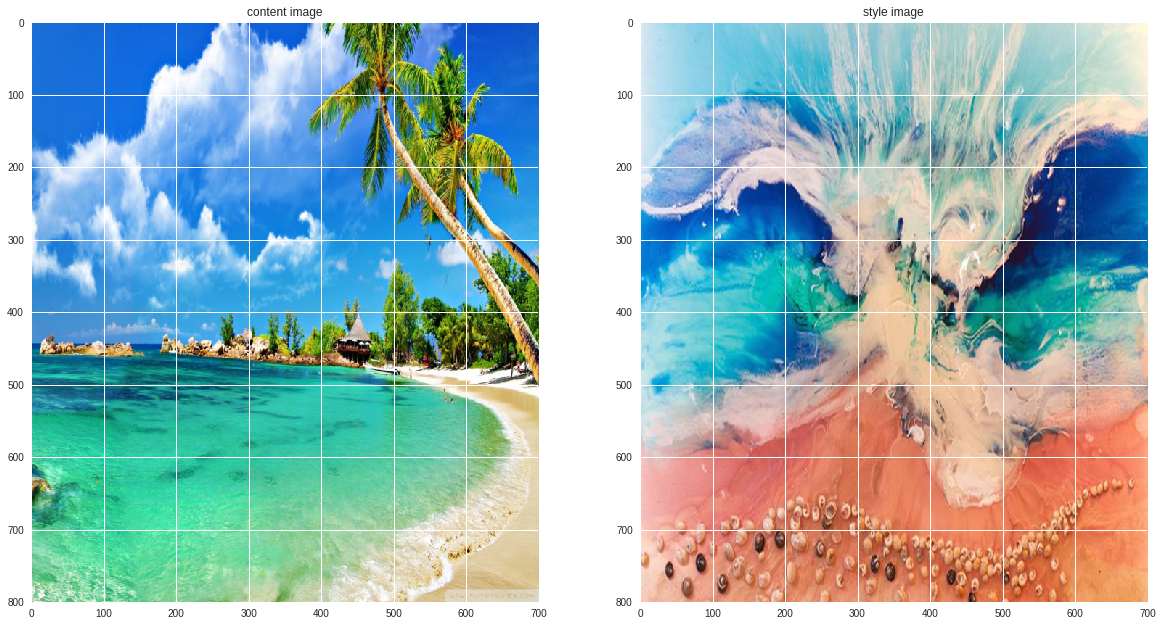

In [17]:
#visualizing the images
fig ,(ax1 , ax2) = plt.subplots(1,2 , figsize=(20,20))
ax1.imshow(denormalize(content))
ax1.set_title("content image")
ax2.imshow(denormalize(style))
ax2.set_title("style image")

# Deep Dream
![](https://cdn-images-1.medium.com/max/800/1*SFgIqRXLDE03_sUWNnxFzQ.png)

So the deep dream algorithm is very simple and helps to understand what every convolution layer is learning.

In deep dream algo we want to maximize the activation of a specific layer in a pretrained network for a given input image so while computing loss we take the norm of the feature map and perform a gradient ascent operation.

The Steps are:-

1. Take a input image.
2. Downscale it continoulsy
3. Apply the deep dream algo to the last downscaled image
4. Resize it and blend it with the previous downsampled image 
5. Keep on repeating these steps recursively till we get final result.

The reason we are downsampling the image continously and applying gaussion blur to amplify and beautify the final output.

Here is an example

![](https://proxy.duckduckgo.com/iu/?u=http%3A%2F%2Fmemaholic.com%2Fwp-content%2Fuploads%2F2015%2F07%2Fmaxresdefault.jpg&f=1)

In [0]:
#constants
IMAGE_PATH = Path("content.jpg") # The path of the image on which deep dream algo has to be executed
LAYER_ID = 20 #Which layers activation you want to be maximized 
NUM_ITERATIONS=5 #No of iterations to update the  image with gradients 
LR=0.2  

# Here the original image is downsampled recursevly by half of the size and then a temporary image is generated using deep dream algo 
# which is then scaled up and blended with the original image
NUM_DOWNSCALES=20
BLEND_ALPHA=0.6
# The image size
SIZE=(600,600)


In [84]:
image = Image.open(IMAGE_PATH).resize(SIZE) 
model = models.vgg16(pretrained=True).features.to(device)
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
def deepDream(image,layer,iteration,lr): #here image is a pil image
    input = transforms.ToTensor()(image).unsqueeze(dim=0).to(device).requires_grad_(True) # convert pil image to tensor

    for _ in range(iteration):
      out=input
      for i in range(layer+1):
        out = model[i](out) # get the feature map till a given layer
      loss = out.norm() # take the norm for a feature map because norm is the maximum magnitude of a vector
      loss.backward() # backward pass
      input.data = input.data + lr *input.grad.data # gradient ascent operation 
      input.grad.zero_() #zero the grad
      
    denorm = denormalize(input.data ,norm=False) # denormalize the image
    return Image.fromarray(np.uint8(denorm*255)) # return a pil image

In [0]:
def deepDreamRecursive(image,layer=LAYER_ID,iteration=NUM_ITERATIONS,lr=LR,num_downscales=NUM_DOWNSCALES):
    if num_downscales>0:

      image_small = image.filter(ImageFilter.GaussianBlur(2))
      small_size = (int(image_small.size[0]/2), int(image_small.size[1]/2))
      
      if (small_size[0] < 1 or small_size[1] < 1):
        small_size = image_small.size      
      
      image_small = image_small.resize(small_size,Image.ANTIALIAS)
      
      image_small = deepDreamRecursive(image_small,layer,iteration,lr,num_downscales-1)
      
      image_small = image_small.resize(image.size,Image.ANTIALIAS)
      image = ImageChops.blend(image,image_small,BLEND_ALPHA)
    
    img_result = deepDream(image,layer,iteration,lr)
    img_result = img_result.resize(image.size)
    return img_result


In [87]:
deepDreamRecursive(image)

The reason we are getiing those psychedelic dope image because when model get an image, if suppose there is a circle in the image the model can recognize thats as an birds face and this algo is trying to amplify that prediction that model made.

# Neural-Style Audio Transfer

In [0]:
def read_audio_spectum(filename):
  x, fs = librosa.load(filename, duration=58.04) # Duration=58.05 so as to make sizes convenient
  S = librosa.stft(x)
  p = np.angle(S)
  S = np.log1p(np.abs(S))  
  return S, fs

In [0]:
style_audio, style_sr = read_audio_spectum("guitar.mp3")
content_audio, content_sr = read_audio_spectum("tabla.mp3")
#output_audio, output_sr = read_audio_spectum(output_audio_name)

In [0]:
style_sr,content_sr

(22050, 22050)

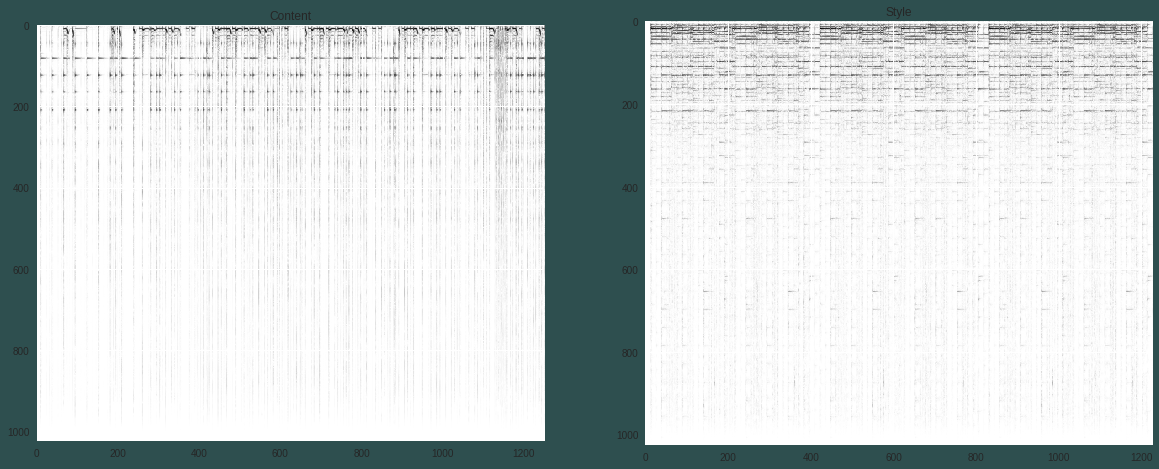

In [0]:
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(20,20),facecolor=(.18, .31, .31))
ax1.set_title('Content')
ax1.imshow(content_audio)
ax2.set_title('Style')
ax2.imshow(style_audio)

In [0]:
class AudioModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv1d(1025,4096,3)
    
  def forward(self ,x):
    out = self.conv1(x)
    return out

In [0]:
content_audio.shape , style_audio.shape

((1025, 1250), (1025, 1228))

In [0]:
a = torch.randn(5,6,7)

In [0]:
a.view(a.shape[0] , -1).shape

torch.Size([5, 42])

In [0]:
a = style_audio.reshape([1,1025,1228])
a = torch.from_numpy(a)
a = a.to(device)

In [0]:
c = AudioModel()
c.to(device)
d = c(a)

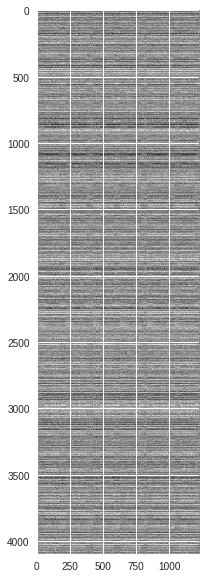

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(d.detach().to("cpu").numpy().squeeze())

In [0]:
c.conv1.weight.shape

torch.Size([4096, 1025, 3])

In [0]:
rm *.jpg *.jpg.1

TypeError: ignored

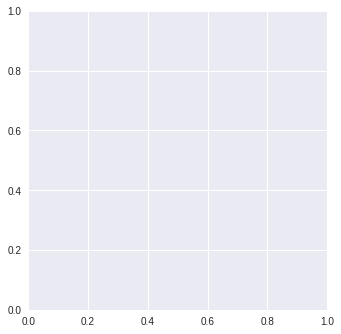

In [0]:
from 

In [44]:
!ls

content.jpg  deepDreamImage.jpg  finalResult.jpg  sample_data  style.jpg
